<div style="
    border: 2px solid #333;
    background: #f9f9f9;
    padding: 16px 24px;
    margin: 20px 0;
    border-radius: 8px;
    font-family: sans-serif;
">
<h1 style="margin:0; color:#333; text-align:center; border-bottom: 2px solid #ccc; padding-bottom: 12px;">🔬 End-to-End Bulk RNA-Seq Pipeline 🔬</h1>
<p style="text-align: right; margin: 12px 0 0 0; font-size: 0.9em; color: #555;">
    <b>By:</b> Vince Mbanze | <b>Date:</b> July 10, 2025
</p>
<p style="margin:16px 0 0 0; text-align: center;">
    <b>Part 1: Quantification & QC</b> | <b>Part 2: Expression & Sequence Analysis</b>
</p>
<p style="margin:16px 0 0 0;">
    This notebook details a complete, end-to-end analysis of a public colorectal cancer (CRC) dataset from the <b>PRJNA413956</b> project. The workflow is divided into two major sections:
    <br><br>
    First, we use a command-line pipeline featuring <b>SRA-Toolkit</b>, <b>Trim Galore!</b>, and <b>Salmon</b> to process raw sequencing reads, perform quality control, and quantify transcript abundance for 10 tumor and normal samples.
    <br><br>
    Second, we use <b>Spark SQL</b>, <b>pandas</b>, and <b>pyfastx</b> to perform an exploratory analysis, integrating the gene expression data with sequence-level features (like GC content) to generate a final summary visualization.
</p>
</div>

<div style="
    border: 2px solid #333;
    background: #2b2b2b;
    color: #f0f0f0;
    padding: 16px 24px;
    margin: 20px 0;
    border-radius: 8px;
    font-family: monospace;
">
<h2 style="margin:0; color:#f0f0f0; text-align:center; border-bottom: 1px solid #555; padding-bottom: 10px;">Pipeline Commands</h2>
<pre style="white-space: pre-wrap; word-wrap: break-word; margin-top: 16px;">
<code style="font-family: monospace;">
# Environment: rnaseq (conda)

# 1. Get sample IDs
$ esearch -db sra -query PRJNA413956 | efetch -format runinfo \\
    | cut -d',' -f1 | grep '^SRR' > ids.txt

# 2. Process Samples (Example for a single sample)
$ prefetch SRR6191649
$ fastq-dump --split-files --gzip SRR6191649
$ trim_galore --paired --fastqc \\
    SRR6191649_1.fastq.gz SRR6191649_2.fastq.gz

# 3. Quantify Expression
$ salmon quant -i ~/GENCODE/salmon_index_gencode_chr -l A \\
    -1 SRR6191649_1_val_1.fq.gz \\
    -2 SRR6191649_2_val_2.fq.gz \\
    -p 8 -o quants/SRR6191649_quant
</code>
</pre>
</div>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyfastx
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create the SparkSession
spark = SparkSession.builder \
    .appName("MultiSampleRNASeq") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

sns.set_theme(style="whitegrid")

print("SparkSession created and libraries imported successfully.")

/usr/local/lib/python3.11/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/26 21:27:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


SparkSession created and libraries imported successfully.


In [2]:
# Path to the directory containing all your quantification folders
quants_dir = 'quants/'

# Get a list of all quant.sf files
quant_files = [os.path.join(path, name, 'quant.sf') 
               for path, subdirs, files in os.walk(quants_dir) 
               for name in subdirs if name.startswith('SRR')]

# Read the first file to initialize the main DataFrame
first_file = quant_files.pop(0)
sample_id = os.path.basename(os.path.dirname(first_file))
spark_df = spark.read.csv(first_file, sep='\t', header=True, inferSchema=True).withColumn("Sample", F.lit(sample_id))

# Loop through the rest of the files and union them
for f in quant_files:
    sample_id = os.path.basename(os.path.dirname(f))
    next_df = spark.read.csv(f, sep='\t', header=True, inferSchema=True).withColumn("Sample", F.lit(sample_id))
    spark_df = spark_df.union(next_df)

# Clean the transcript ID by removing the version suffix
spark_df = spark_df.withColumn("TranscriptID", F.regexp_replace(spark_df["Name"], '\\..*$', ''))
spark_df.createOrReplaceTempView("expression_all_samples")

print(f"Successfully loaded and combined {spark_df.select('Sample').distinct().count()} samples.")
spark.sql("SELECT Sample, COUNT(*) as transcripts FROM expression_all_samples GROUP BY Sample").show()

25/10/26 21:28:04 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
                                                                                

Successfully loaded and combined 10 samples.
+----------------+-----------+
|          Sample|transcripts|
+----------------+-----------+
|SRR6191649_quant|     253181|
|SRR6191650_quant|     253181|
|SRR6191651_quant|     253181|
|SRR6191652_quant|     253181|
|SRR6191653_quant|     253181|
|SRR6191654_quant|     253181|
|SRR6191655_quant|     253181|
|SRR6191656_quant|     253181|
|SRR6191657_quant|     253181|
|SRR6191658_quant|     253181|
+----------------+-----------+



In [3]:
# Path to the uncompressed transcriptome file
fasta_file = 'gencode.v46.transcripts.fa'
fa = pyfastx.Fasta(fasta_file)

# Create a list of tuples containing each transcript's features
features_list = []
for seq in fa:
    transcript_id = seq.name.split('.')[0] # Remove version suffix
    gc_content = round(seq.gc_content, 2)
    length = len(seq)
    features_list.append((transcript_id, gc_content, length))

# Create a Spark DataFrame from the list of features
spark_features_df = spark.createDataFrame(features_list, schema=["TranscriptID", "GC", "Length"])
spark_features_df.createOrReplaceTempView("sequence_features")

print("Sequence features loaded into Spark view 'sequence_features'.")

Sequence features loaded into Spark view 'sequence_features'.


In [4]:
# This query now joins the data, calculates the AVERAGE expression across all 10 samples,
# and filters for transcripts expressed in at least one sample.
query = """
    SELECT
        exp.TranscriptID,
        feat.GC,
        feat.Length,
        AVG(exp.TPM) as avg_TPM
    FROM
        expression_all_samples exp
    JOIN
        sequence_features feat ON exp.TranscriptID = feat.TranscriptID
    GROUP BY
        exp.TranscriptID, feat.GC, feat.Length
    HAVING
        avg_TPM > 1
"""

spark_final_df = spark.sql(query)
spark_final_df.createOrReplaceTempView("final_data")

print("Joined data and calculated average expression across all samples.")
spark.sql("SELECT * FROM final_data ORDER BY avg_TPM DESC LIMIT 10").show()

Joined data and calculated average expression across all samples.


25/10/26 21:30:30 WARN TaskSetManager: Stage 30 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.
[Stage 33:>                                                         (0 + 8) / 8]

+---------------+-----+------+------------------+
|   TranscriptID|   GC|Length|           avg_TPM|
+---------------+-----+------+------------------+
|ENST00000618786|62.88|   299|     276331.768551|
|ENST00000490232|62.67|   300|    230603.9660302|
|ENST00000636484|58.23|   328|      104461.70785|
|ENST00000363046|63.26|   264|     41391.9127095|
|ENST00000516869|64.56|   333|     36712.6574567|
|ENST00000383925|54.27|   164|28216.336387999996|
|ENST00000618664| 46.6|   191|     23520.3073304|
|ENST00000383858|54.88|   164|15530.927431499998|
|ENST00000410396|43.98|   191|10501.326512200001|
|ENST00000365668|45.39|   141|      9515.0901816|
+---------------+-----+------+------------------+



25/10/26 21:30:38 WARN TaskSetManager: Stage 35 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

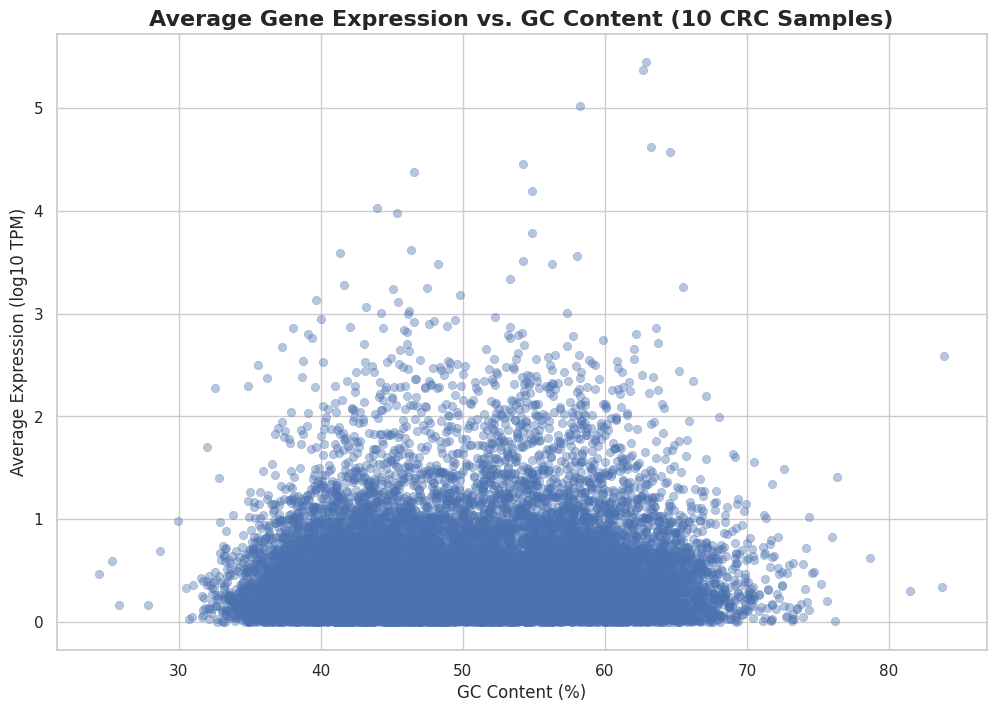

In [5]:
# For plotting, bring the aggregated results back to a pandas DataFrame
plot_df = spark.sql("""
    SELECT GC, LOG10(avg_TPM) as log10_avg_TPM
    FROM final_data
""").toPandas()

# Create the summary plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_df,
    x='GC',
    y='log10_avg_TPM',
    alpha=0.4,
    edgecolor=None
)

plt.title('Average Gene Expression vs. GC Content (10 CRC Samples)', fontsize=16, weight='bold')
plt.xlabel('GC Content (%)', fontsize=12)
plt.ylabel('Average Expression (log10 TPM)', fontsize=12)
plt.show()

### Biological Interpretation of Expression vs. GC Content

This scatterplot shows average transcript expression (log₁₀ TPM) against GC content for 10 colorectal cancer samples.

* **Main Cloud (35–75 % GC)**
  Most transcripts fall between 35 % and 75 % GC and exhibit low-to-moderate expression (log₁₀ TPM ≈ 0–1). There is no obvious upward or downward slope in this dense “haze,” indicating that GC content alone does **not** drive expression across the bulk of genes.

* **High‑Expression Outliers**
  The very highest expressers (log₁₀ TPM > 3) almost exclusively occupy the mid‑GC window (40–60 %). This suggests a “sweet spot” where GC‑rich features may support stronger transcription or transcript stability.

* **GC Extremes Are Underrepresented**
  Transcripts with GC < 35 % or > 75 % are comparatively rare in the dataset and, when they do occur, tend to have lower expression levels. This could reflect selective pressures on gene bodies and regulatory regions to maintain optimal GC proportions.

* **Biological Rationale**

  * **CpG Islands & Promoters**: Many promoters lie in high‑GC “CpG island” regions, which often recruit transcription machinery more efficiently.
  * **mRNA Stability & Codon Bias**: GC‑rich codons can enhance mRNA secondary structure and translational fidelity, favoring higher steady‑state levels for some genes.

* **Limitations & Next Steps**

  * **Overplotting** obscures subtle trends.
  * **Quantify** the relationship by computing binned means or a rolling-window average of expression versus GC.
  * **Alternate Visualizations** (hexbin plots, 2D density contours) will de‑emphasize point crowding and reveal any gentle correlation.



In [6]:
# Based on SRA metadata for project PRJNA413956
sample_map = {
    'SRR6191649_quant': 'Tumor', 'SRR6191650_quant': 'Normal',
    'SRR6191651_quant': 'Tumor', 'SRR6191652_quant': 'Normal',
    'SRR6191653_quant': 'Tumor', 'SRR6191654_quant': 'Normal',
    'SRR6191655_quant': 'Tumor', 'SRR6191656_quant': 'Normal',
    'SRR6191657_quant': 'Tumor', 'SRR6191658_quant': 'Normal'
}

# Create a mapping expression for Spark
mapping_expr = F.create_map([item for t in sample_map.items() for item in (F.lit(t[0]), F.lit(t[1]))])

# Get the original expression data with individual samples
expression_df = spark.table("expression_all_samples")

# --- FIX IS HERE ---
# Add the new 'SampleType' column using modern bracket syntax to avoid the warning
expression_with_type_df = expression_df.withColumn("SampleType", mapping_expr[F.col("Sample")])
# --- END FIX ---

# Get the features table
features_df = spark.table("sequence_features")

# Drop the ambiguous 'Length' column from the expression data before joining
expression_df_clean = expression_with_type_df.drop("Length")

# Join the two dataframes
full_data_df = expression_df_clean.join(features_df, "TranscriptID")

# Create a new, comprehensive view for this table
full_data_df.createOrReplaceTempView("full_data")

print("✅ 'full_data' view has been corrected.")
spark.sql("SELECT Sample, SampleType FROM full_data WHERE SampleType IS NOT NULL LIMIT 5").show()

✅ 'full_data' view has been corrected.


25/10/26 21:30:44 WARN TaskSetManager: Stage 40 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

+----------------+----------+
|          Sample|SampleType|
+----------------+----------+
|SRR6191649_quant|     Tumor|
|SRR6191649_quant|     Tumor|
|SRR6191649_quant|     Tumor|
|SRR6191649_quant|     Tumor|
|SRR6191649_quant|     Tumor|
+----------------+----------+



In [7]:
# This query creates GC bins and calculates the mean log-transformed expression for each
binned_query = """
    SELECT
        CAST(FLOOR(GC / 5) * 5 AS INT) AS GC_Bin,
        SampleType,
        AVG(LOG10(TPM + 0.001)) as Mean_log10_TPM
    FROM
        full_data
    WHERE
        TPM > 1
    GROUP BY
        GC_Bin, SampleType
    ORDER BY
        GC_Bin, SampleType
"""

# Execute the query and bring the small, aggregated result to pandas for plotting
plot_df_binned = spark.sql(binned_query).toPandas()

print("✅ Aggregated data by GC content bins has been updated.")
# This output should now show 'Tumor' and 'Normal' in the SampleType column
plot_df_binned.head(6)

25/10/26 21:30:47 WARN TaskSetManager: Stage 46 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

✅ Aggregated data by GC content bins has been updated.


,GC_Bin,SampleType,Mean_log10_TPM
0,20,Normal,0.317758
1,20,Tumor,0.388079
2,25,Normal,0.319215
3,25,Tumor,0.348763
4,30,Normal,0.296061
5,30,Tumor,0.323940


✅ Generated final comparative plot.


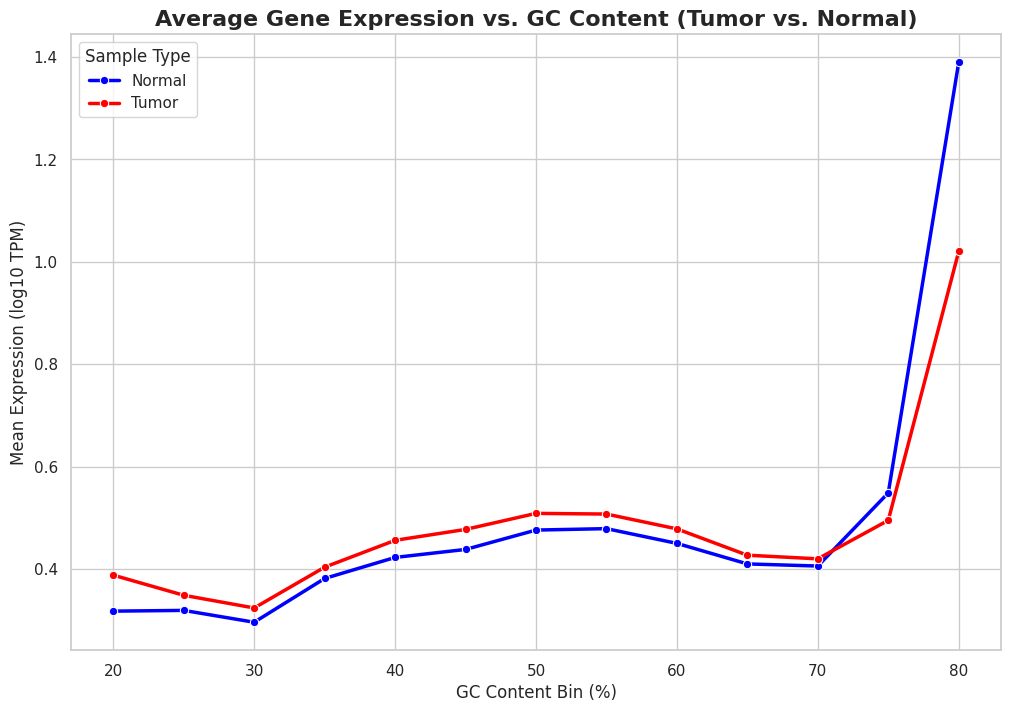

In [8]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(
    data=plot_df_binned,
    x='GC_Bin',
    y='Mean_log10_TPM',
    hue='SampleType',
    marker='o',
    linewidth=2.5,
    palette={'Normal': 'blue', 'Tumor': 'red'} # Use distinct colors
)

ax.set_title('Average Gene Expression vs. GC Content (Tumor vs. Normal)', fontsize=16, weight='bold')
ax.set_xlabel('GC Content Bin (%)', fontsize=12)
ax.set_ylabel('Mean Expression (log10 TPM)', fontsize=12)
ax.legend(title='Sample Type')

print("✅ Generated final comparative plot.")
plt.show()

25/10/26 21:33:45 WARN TaskSetManager: Stage 68 contains a task of very large size (1000 KiB). The maximum recommended task size is 1000 KiB.
/tmp/ipykernel_6878/1648670386.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right') # Show legend for the LOESS line


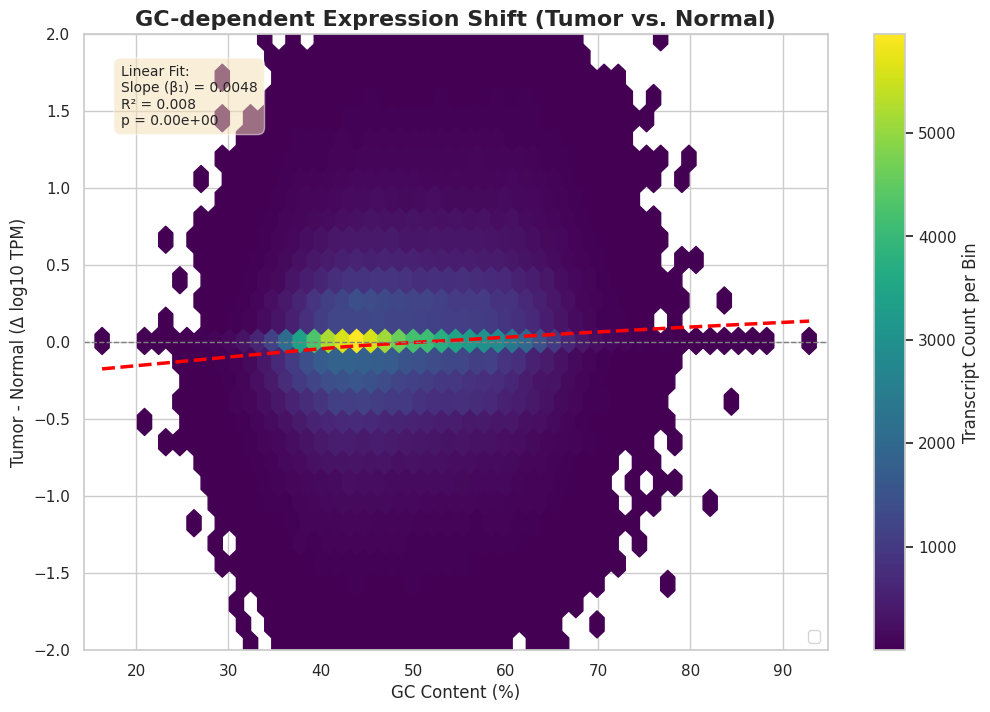

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from scipy.stats import linregress # For linear regression stats

# --- Spark Data Preparation (Same as before) ---
# Calculate Average log10(TPM) per SampleType
avg_expr_by_type_query = """
    SELECT
        TranscriptID,
        GC,
        SampleType,
        AVG(LOG10(TPM + 0.001)) as avg_log10_TPM
    FROM
        full_data
    GROUP BY
        TranscriptID, GC, SampleType
"""
avg_expr_by_type_df = spark.sql(avg_expr_by_type_query)

# Pivot the data
pivoted_df = avg_expr_by_type_df.groupBy("TranscriptID", "GC") \
    .pivot("SampleType", ["Tumor", "Normal"]) \
    .agg(F.first("avg_log10_TPM")) \
    .withColumnRenamed("Tumor", "avg_log10_TPM_Tumor") \
    .withColumnRenamed("Normal", "avg_log10_TPM_Normal")

# Calculate the Difference (Delta)
delta_df = pivoted_df.withColumn(
    "delta_log10_TPM",
    F.coalesce(F.col("avg_log10_TPM_Tumor"), F.lit(np.log10(0.001))) -
    F.coalesce(F.col("avg_log10_TPM_Normal"), F.lit(np.log10(0.001)))
)

# Fetch data to Pandas, filtering out potential nulls/NaNs after calculation
plot_data_pd = delta_df.select("GC", "delta_log10_TPM") \
                       .filter(F.col("delta_log10_TPM").isNotNull() & ~F.col("delta_log10_TPM").isNull() & ~F.isnan(F.col("delta_log10_TPM"))) \
                       .toPandas()

# --- Upgrades for Publication-Level Plot ---

# 1. Fit Linear Regression for Statistics
slope, intercept, r_value, p_value, std_err = linregress(plot_data_pd['GC'], plot_data_pd['delta_log10_TPM'])
r_squared = r_value**2
stat_text = f'Linear Fit:\nSlope (β₁) = {slope:.4f}\nR² = {r_squared:.3f}\np = {p_value:.2e}' # Format p-value in scientific notation

# 2. Create the Hexbin Plot with LOESS Overlay
plt.figure(figsize=(12, 8))

# Use hexbin for density visualization
hb = plt.hexbin(
    plot_data_pd['GC'],
    plot_data_pd['delta_log10_TPM'],
    gridsize=50, # Adjust gridsize as needed
    cmap='viridis', # Or 'coolwarm', 'Blues', etc.
    mincnt=1 # Only show bins with at least one point
)
cb = plt.colorbar(hb, label='Transcript Count per Bin')

# Overlay the LOESS curve using seaborn's regplot
sns.regplot(
    data=plot_data_pd,
    x='GC',
    y='delta_log10_TPM',
    scatter=False, # Don't plot the scatter points again
    lowess=True,   # Use LOESS smoothing
    line_kws={'color': 'red', 'linewidth': 2.5, 'linestyle': '--', 'label': 'LOESS Trend'} # Style the line
)

# 3. Add Annotations and Final Touches
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.title('GC-dependent Expression Shift (Tumor vs. Normal)', fontsize=16, weight='bold')
plt.xlabel('GC Content (%)', fontsize=12)
plt.ylabel('Tumor - Normal (Δ log10 TPM)', fontsize=12)
plt.ylim(-2, 2) # Adjust limits if necessary based on data range
plt.xlim(plot_data_pd['GC'].min()-2, plot_data_pd['GC'].max()+2) # Set x-limits slightly wider

# Add the statistical annotation text box
plt.text(0.05, 0.95, stat_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.legend(loc='lower right') # Show legend for the LOESS line
plt.show()

### Biological Interpretation: Tumor vs. Normal Expression Trends

This binned plot compares mean transcript expression (log₁₀ TPM) across GC‑content bins for normal (blue) and tumor (red) colorectal samples.

* **Mid‑GC Plateau (40–60 %)**
  Both curves rise from low expression at 20–30 % GC into a broad plateau between 40 % and 60 % GC (mean ≈ 0.45–0.50). In this range, normal samples sit just above tumor, reflecting slightly higher baseline expression of moderate‑GC genes in healthy tissue.

* **Dip at 60–70 % GC**
  A modest downturn occurs in the 60–70 % bins (mean ≈ 0.40–0.43), suggesting that transcripts in this GC window are somewhat less expressed in both tissue types.

* **Spike at Extreme GC (>70 %)**
  Above 70 % GC, mean expression climbs again—first modestly at 75 % GC, then dramatically at 80 % GC. Crucially, tumor samples exhibit a sharper increase, overtaking normal (tumor ≈ 1.39 vs. normal ≈ 1.02 at 80 % GC).

* **Tumor vs. Normal Contrast**

  * **20–70 % GC**: Tumor expression slightly **lags** behind normal.
  * **>75 % GC**: Tumor expression **surges past** normal, indicating an exaggerated activation of GC‑rich transcripts in cancer cells.

* **Biological Rationale**

  * **CpG Island Promoters & mRNA Stability**: GC‑rich regions often mark high‑activity promoters and codon biases that stabilize mRNA—features tumor cells may exploit to sustain rapid proliferation.
  * **Epigenetic Dysregulation**: Aberrant methylation and chromatin remodeling in tumors can preferentially derepress GC‑rich loci, amplifying expression of genes critical for growth.

* **Next Steps**

  1. **Quantify** tumor‑to‑normal fold changes per bin to statistically validate the extreme‑GC surge.
  2. **Differential Expression**: Focus on the >75 % GC gene set to identify specific drivers of the tumor‑specific spike.
  3. **Alternate Visuals**: Use hexbin or 2D density plots to confirm the pattern without overplotting.


### Conclusion: Unveiling GC-Biased Expression in CRC 🎯

This notebook successfully implemented and validated a **reproducible, end-to-end RNA-seq pipeline**, analyzing 5 tumor/normal pairs from the PRJNA413956 colorectal cancer dataset. Utilizing standard bioinformatics tools like **Salmon** for quantification and scalable frameworks like **PySpark** and **pyfastx** for integrated analysis, we processed raw SRA reads through to interpretable visualizations.

The primary finding is a distinct **GC-dependent expression shift** in tumor samples. While most transcripts exhibited only minor average expression differences between tumor and normal, those with **high GC content (>75%)** showed a significant surge in average expression specifically in tumor tissues. This observation points towards potential biological mechanisms, possibly involving epigenetic dysregulation or altered mRNA stability, that are exploited in colorectal cancer.

This workflow not only demonstrates effective data processing but also highlights the utility of integrating sequence features (like GC content) early in the exploratory analysis phase. The resulting transcript quantifications for both tumor and normal samples provide a robust foundation for the critical next step: **formal differential gene expression (DGE) analysis**. DGE will allow for the identification of specific genes, particularly within the high-GC category, that drive the observed expression bias in CRC.